In [2]:
import numpy as np
from matplotlib import pyplot as plt

import h5py
import numpy as np

# Include parent directory in sys.path to import local modules
import glob
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)



### Writing to HDF5 files ###
def _save_dict_to_h5(group, data_dict):
    for key, value in data_dict.items():
        if isinstance(value, dict):
            # If it's a dictionary, create a new group
            new_group = group.create_group(key)
            _save_dict_to_h5(new_group, value) # Recursively call for nested dict
        else:
            # # Check if numpy array or standard python type
            # if not isinstance(value, np.ndarray) or not isinstance(value, (int, float, str, bool)):
            #     raise ValueError(f"Value for key '{key}' is not a numpy array.")
            # if value.ndim > 2:
            #     raise ValueError(f"Value for key '{key}' has more than 2 dimensions, which is not supported.")
            # If it's an array, create a dataset
            group.create_dataset(key, data=value)


def save_to_hdf5(my_data, filename):
    """
    Save a dictionary of numpy arrays to an HDF5 file.

    Parameters:
    my_data (dict): Dictionary where keys are dataset names and values are numpy arrays.
    file_name (str): Name of the output HDF5 file.
    """
    # 1. Open a new HDF5 file
    # 2. Create datasets for each array in the dictionary
    with h5py.File(filename, 'w') as f:
        _save_dict_to_h5(f, my_data)


### Reading from HDF5 files ###

def _load_dict_from_h5(group):
    data_dict = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            # If it's a group, recursively load it
            data_dict[key] = _load_dict_from_h5(item)
        else:
            # Otherwise, it's a dataset
            data = item[()]
            if isinstance(data, bytes):
                # Decode bytes to string if necessary
                data_dict[key] = data.decode("utf-8")
            else:
                data_dict[key] = data
    return data_dict


def load_from_hdf5(filename):
    """
    Recursively load a nested dictionary of numpy arrays from an HDF5 file.

    Parameters:
    filename (str): Name of the HDF5 file to read.
    Returns:
    dict: A dictionary where keys are dataset names and values are numpy arrays.
    """

    with h5py.File(filename, 'r') as f:

        return _load_dict_from_h5(f)
    

def load_key_from_hdf5(filename, key):
    """
    Load a specific key from an HDF5 file.

    Parameters:
    filename (str): Name of the HDF5 file to read.
    key (str): The key to load from the file.

    Returns:
    The data associated with the specified key.
    """
    with h5py.File(filename, 'r') as f:
        if key in f:
            if isinstance(f[key], h5py.Group):
                # If it's a group, recursively load it
                return _load_dict_from_h5(f[key])
            else:
                return f[key][()]
        else:
            raise KeyError(f"Key '{key}' not found in the file '{filename}'.")        

## Setting the filename

In [106]:
saving_plots = False

folder_path = "/Users/arash/Downloads/plotting adams data/data_20250912/"
# folder_path = "/Users/arash/Julia Projects/Quantum_Trajectory_Adam/QuantumChannelTrajectories.jl/data/"

fermions = True # Whether to use fermionic statistics
dt = 0.01
p = 2*dt#0.5
Nx = 4
Ny = 4
N = Nx*Ny
V = 0.0
b = 0.5 #2/((Nx-1)*(Ny-1))  # Magnetic field strength
num_iterations = 9922
steps = 1000
initialization = False

site_in = 1  # Site where the current is injected
drive_type = "current"  # :current, :dephasing
initial_state = "random"  # :checkerboard, :empty, :filled, :random, :custom
B = b*np.pi # Magnetic field in units of flux quantum
site_out = N  # Site where the current is extracted
even_parity = False  # Whether to use even parity
pinned_corners = True  # Whether to pin the corners of the lattice
single_shot = False  # Whether to perform single shot measurements

trotter_evo = False
cir_typ = "Adam" #"Anna"

suffix = "_Adam" if not fermions else ""

if fermions:
    # filename = "fermions_"
    particle_name = "fermions"
else:
    # filename = "bosons_"
    particle_name = "bosons"

filename = f"{Nx}x{Ny}_dt{dt}_p{p}_b{b}_V{V}_steps{steps}_trajectories{num_iterations}_{drive_type}_{initial_state}"
if initialization:
    filename += "_NESS"
if even_parity:
    filename += "_even_parity"
if pinned_corners:
    filename += "_pinned_corners"
if single_shot:
    filename += "_single_shot"
if trotter_evo:
    filename += "_trotter"
    if not fermions:
        filename += "_"+cir_typ

# filename += "_run1"

params = load_key_from_hdf5(folder_path+f"{particle_name}_"+f"{filename}.h5", "params")


newpath = folder_path +'plots/'+particle_name+f'/' 
if not os.path.exists(newpath) and saving_plots:
    print("file created")
    os.makedirs(newpath)



---
# Plotting Density Trace

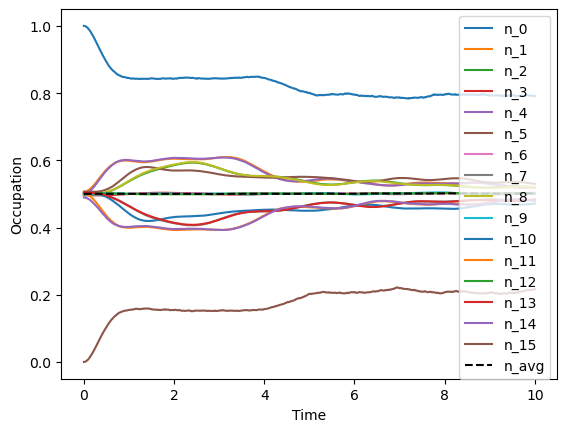

In [75]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny


for i in range(N):
    plt.plot(t_list, n_avg[i,:], label=f"n_{i}")
plt.plot(t_list, np.sum(n_avg, axis=0)/(N), '--', c='k', label="n_avg")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.legend()

if saving_plots:
    plt.savefig(newpath + "density_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)


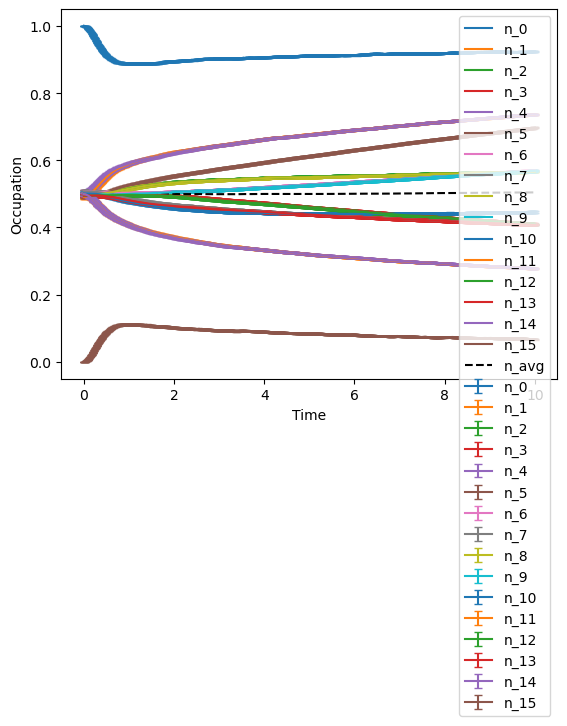

In [5]:

n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg")
n_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_sq_avg")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny

sem = np.sqrt(n_sq_avg - n_avg**2)/np.sqrt(num_iterations)

for i in range(N):
    plt.errorbar(t_list, n_avg[i,:], yerr=sem[i,:], label=f"n_{i}", capsize=3, color=f"C{i}")
    plt.fill_between(t_list, n_avg[i,:] - sem[i,:], n_avg[i,:] + sem[i,:], alpha=0.2, color=f"C{i}")
    plt.plot(t_list, n_avg[i,:], label=f"n_{i}", color=f"C{i}")
    

plt.plot(t_list, np.sum(n_avg, axis=0)/N, '--', c='k', label="n_avg")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.legend()

# plt.savefig(newpath + "density_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)
# plt.savefig(f"../figures/fermion_density_4x4_dt{dt}_p{p}_b{b}_V{V}_tajectories{num_iterations}.png", bbox_inches='tight', pad_inches=0.1, dpi=300)

## Log-plot of densities

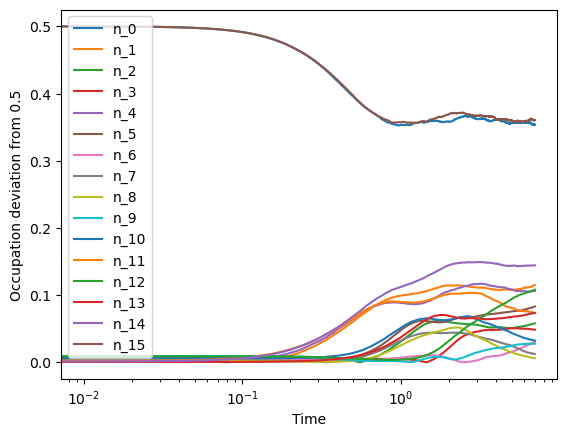

In [ ]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny

for i in range(N):
    plt.plot(t_list, np.abs(n_avg[i,:]-0.5), label=f"n_{i}")
plt.xlabel("Time")
plt.ylabel("Occupation deviation from 0.5")
plt.legend()
plt.xscale("log")

if saving_plots:
    plt.savefig(newpath+"logDensity_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)


---
# Current trace

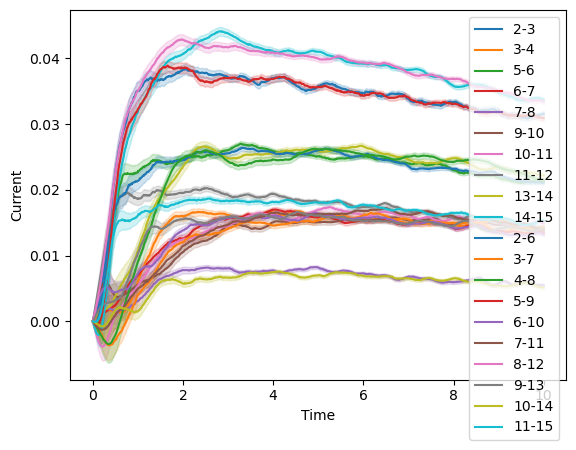

In [104]:
avg_currents = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents")
currents_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "currents_sq_avg")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

sem_currents = np.sqrt(currents_sq_avg - avg_currents**2)/np.sqrt(num_iterations)

for i, bond in enumerate(bonds):
    plt.fill_between(t_list, avg_currents[i,:] - sem_currents[i,:], avg_currents[i,:] + sem_currents[i,:], alpha=0.2, color=f"C{i}")
    plt.plot(t_list, avg_currents[i,:], label=f"{bond[0]}-{bond[1]}", color=f"C{i}")
plt.xlabel("Time")
plt.ylabel("Current")
plt.legend()

if saving_plots:
    plt.savefig(newpath + "current_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)


---
# NESS Snapshot

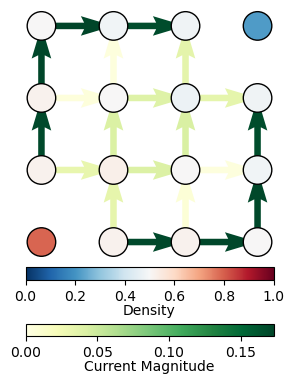

In [107]:
# dt=0.25
# file = glob.glob(f"{particle_name}_4x4_dt{dt}_p{2*dt}_b{b}_V{V}_steps20_trajectories????_current_random_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0]
# n_avg = load_key_from_hdf5(folder_path+file, "n_avg").T
# avg_currents = load_key_from_hdf5(folder_path+file, "avg_currents").T
# params = load_key_from_hdf5(folder_path+file, "params")
# t_list = load_key_from_hdf5(folder_path+file, "t_list")
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg").T
avg_currents = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents").T
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']


########################################################################################################################################################################################
time_step = -1
# filename = f"{Nx}x{Ny}_dt{dt}_p{p}_b{b}_V{V}_steps{time_step}_trajectories{num_iterations}_{drive_type}_{initial_state}"
# if even_parity:
#     filename += "_even_parity"
# if pinned_corners:
#     filename += "_pinned_corners"
# if single_shot:
#     filename += "_single_shot"
# if trotter_evo:
#     filename += "_trotter"
#     if not fermions:
#         filename += "_"+cir_typ
########################################################################################################################################################################################



plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 750 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.035 * 3/Nx  # Width of the arrows in the quiver plot

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U1 = []; U2 = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = (bond[0]-1) % Nx, (bond[0]-1) // Nx
    x2, y2 = (bond[1]-1) % Nx, (bond[1]-1) // Nx

    if np.abs(avg_currents[time_step,i]) > plotting_threshold*np.abs(avg_currents[time_step,:]).max():
        C.append(np.abs(avg_currents[time_step,i]))

        if np.real(avg_currents[time_step,i]) > 0:
            X.append(x1)
            Y.append(y1)
            U1.append(x2-x1)
            U2.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U1.append(x1-x2)
            U2.append(y1-y2)

fig, ax = plt.subplots()

p1 = ax.quiver(X, Y, U1, U2, C, cmap="YlGn", angles='xy', scale_units='xy', scale=1, width=arrow_width)
p1.set_clim(0, np.max(C))
cb1 = plt.colorbar(p1, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb1.set_label('Current Magnitude', labelpad=0)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(n_avg[time_step,n])

p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)
cb2 = plt.colorbar(p2, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb2.set_label('Density', labelpad=0)

# Add automatic padding to prevent cutoff
ax.margins(0.1 * 3/Nx)  # Add padding around the data
# Alternatively, you could use: ax.set_xlim(-0.5, Nx-0.5); ax.set_ylim(-0.5, Ny-0.5)

ax.set_axis_off()
ax.set_aspect('equal')

if saving_plots:
    plt.savefig(newpath + "NESS_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)


## Time-Averaged Snapshot

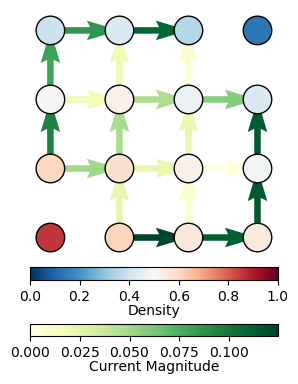

In [47]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg").T
avg_currents = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents").T
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 750 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.035 * 3/Nx  # Width of the arrows in the quiver plot


time_averaged_currents = np.mean(avg_currents[7*steps//8:-1], axis=0)
time_averaged_n = np.mean(n_avg[7*steps//8:-1], axis=0)

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U = []; V = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = (bond[0]-1) % Nx, (bond[0]-1) // Nx
    x2, y2 = (bond[1]-1) % Nx, (bond[1]-1) // Nx

    if np.abs(time_averaged_currents[i]) > plotting_threshold*np.abs(time_averaged_currents).max():
        C.append(np.abs(time_averaged_currents[i]))

        if np.real(time_averaged_currents[i]) > 0:
            X.append(x1)
            Y.append(y1)
            U.append(x2-x1)
            V.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U.append(x1-x2)
            V.append(y1-y2)

fig,ax = plt.subplots()

p1 = ax.quiver(X, Y, U, V, C, cmap="YlGn", angles='xy', scale_units='xy', scale=1, width=arrow_width)
p1.set_clim(0, np.max(C))
cb1 = plt.colorbar(p1, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb1.set_label('Current Magnitude', labelpad=0)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(time_averaged_n[n])


p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)
cb2 = plt.colorbar(p2, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb2.set_label('Density', labelpad=0)

# Add automatic padding to prevent cutoff
ax.margins(0.1)  # Add padding around the data
# Alternatively, you could use: ax.set_xlim(-0.5, Nx-0.5); ax.set_ylim(-0.5, Ny-0.5)

ax.set_axis_off()
ax.set_aspect('equal')
# plt.show()
plt.savefig(newpath + "AVG_NESS_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)


## NESS density pattern

[0.8536335438305088, 0.6149471960147407, 0.5579149868617634, 0.5485305758110891, 0.6063219768156155, 0.5831729739001682, 0.5303103004478311, 0.487587615986961, 0.5062244438736923, 0.5276337304615123, 0.4676579454045243, 0.4265687019193354, 0.39189436657777427, 0.42653315727968494, 0.3556927457941279, 0.13947573902067176]


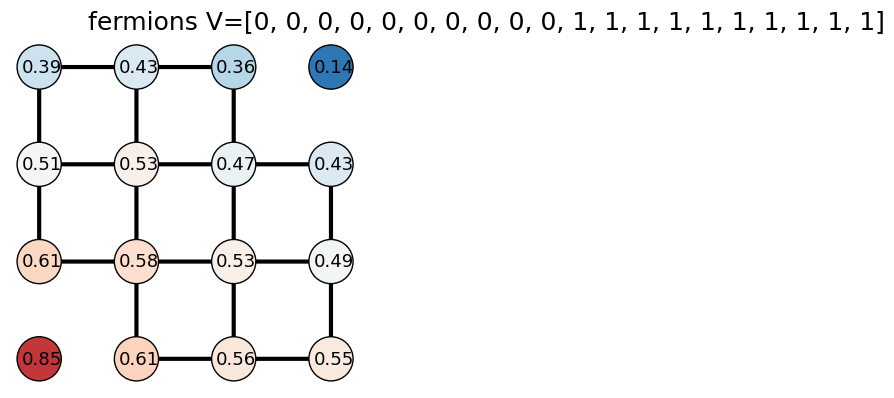

In [48]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg").T
avg_currents = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents").T
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

time_step = -1

plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 1800 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.015 * 3/Nx  # Width of the arrows in the quiver plot

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U1 = []; U2 = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = (bond[0]-1) % Nx, (bond[0]-1) // Nx
    x2, y2 = (bond[1]-1) % Nx, (bond[1]-1) // Nx

    if np.abs(avg_currents[time_step,i]) > plotting_threshold*np.abs(avg_currents[time_step,:]).max():
        # C.append(np.abs(avg_currents[time_step,i]))
        C.append(1.0)

        if np.real(avg_currents[time_step,i]) > 0:
            X.append(x1)
            Y.append(y1)
            U1.append(x2-x1)
            U2.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U1.append(x1-x2)
            U2.append(y1-y2)

fig, ax = plt.subplots()

p1 = ax.quiver(X, Y, U1, U2, C, cmap="binary_r", angles='xy', scale_units='xy', scale=1.0, width=arrow_width, headwidth=0.00)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(n_avg[time_step,n])
        ax.annotate(
            np.round(n_avg[time_step,n],decimals=2), 
            (x-0.18,y-0.05), fontsize=13)

p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)

ax.annotate(particle_name+f" V={V}", (0.5, 3.4), fontsize=18)

# Add padding around the data
ax.set_xlim(-0.3, Nx-0.5); 
ax.set_ylim(-0.3, Ny-0.5)


ax.set_axis_off()
ax.set_aspect('equal')

# plt.savefig(newpath + "_NESS_density_pattern_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

print(list(n_avg[time_step,:]))

---
# Density Correlation matrix

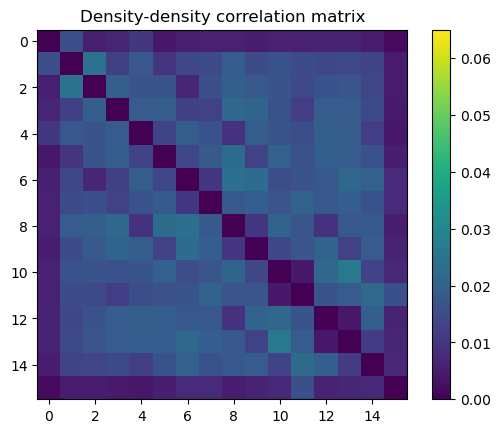

In [ ]:
avg_dd_correlations = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_dd_correlations")

plt.imshow(np.abs(avg_dd_correlations -np.diag(np.diag(avg_dd_correlations))), cmap="viridis", vmin=0)
plt.colorbar()
plt.title("Density-density correlation matrix")
plt.clim([0,0.065])

# plt.show()
if saving_plots:
    plt.savefig(newpath + "correlation_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

# plt.savefig(f"../figures/fermion_correlations_4x4_dt{dt}_p{p}_b{b}_V{V}_tajectories{num_iterations}.pdf", bbox_inches='tight', pad_inches=0.1, dpi=300)


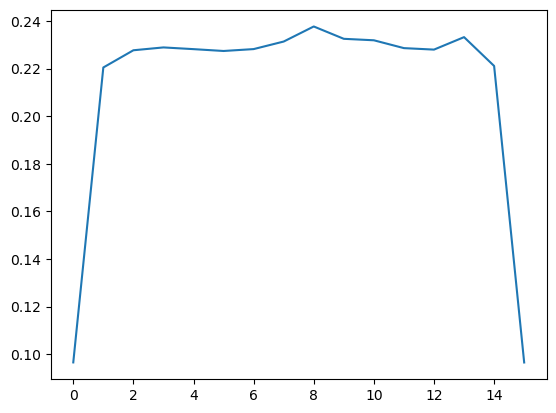

In [50]:
plt.plot(np.diag(avg_dd_correlations))

---
# Equilibrium condition

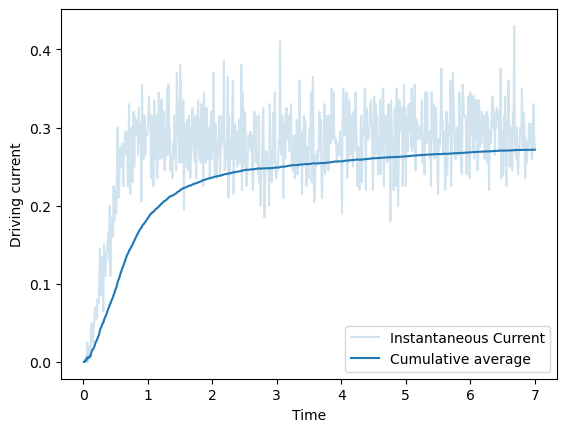

In [ ]:
K_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "K_avg")

driving_current = (K_avg[1,:] + K_avg[4,:] + K_avg[6,:] + K_avg[8,:] + 2*K_avg[7,:]) / 2

plt.plot(t_list[1:], driving_current/dt, alpha=0.2, c="C0", label="Instantaneous Current")

plt.plot(t_list[1:], np.cumsum(driving_current)/t_list[1:], c="C0", label="Cumulative average")

plt.xlabel("Time")
plt.ylabel("Driving current")
plt.legend()

# plt.show()

if saving_plots:
    plt.savefig(newpath + "kraus_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)
# plt.savefig(f"../figures/boson_kraus_4x4_dt{dt}_p{p}_b{b}_V{V}_tajectories{num_iterations}.png", bbox_inches='tight', pad_inches=0.1, dpi=300)

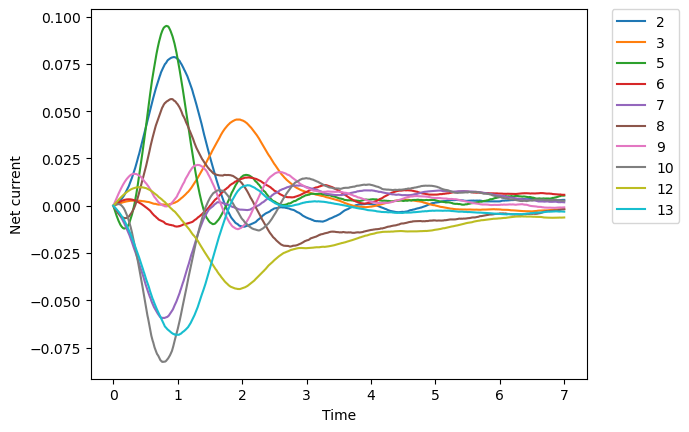

In [ ]:
avg_currents = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents").T
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

currents_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "currents_sq_avg").T
sem_currents = np.sqrt(4)*np.mean(np.sqrt(currents_sq_avg - avg_currents**2)/np.sqrt(num_iterations), axis=1)



net_currents = np.zeros((len(t_list),N))
for site in range(N):

    if site in [0, 1, Nx, N-2, N-Nx-1, N-1]:
        continue

    for ii, bond in enumerate(bonds):

        if bond[0] == site + 1:
            net_currents[:,site] -= avg_currents[:,ii]
        elif bond[1] == site + 1:
            net_currents[:,site] += avg_currents[:,ii]

for site in range(N):
    if site in [0, 1, Nx, N-2, N-Nx-1, N-1]:
        continue
    plt.plot(t_list, net_currents[:,site], label=f"{site}")

# plt.plot(t_list, sem_currents, "--", alpha=0.5, c="k", label="Current standard error")
# plt.plot(t_list, -sem_currents, "--", alpha=0.5, c="k")

plt.xlabel("Time")
plt.ylabel("Net current")
# Legend on right outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0.)


if saving_plots:
    plt.savefig(newpath + "NetCurrent_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)
# plt.savefig(f"../figures/boson_net_current_4x4_dt{dt}_p{p}_b{b}_V{V}_tajectories{num_iterations}.png", bbox_inches='tight', pad_inches=0.1, dpi=300)

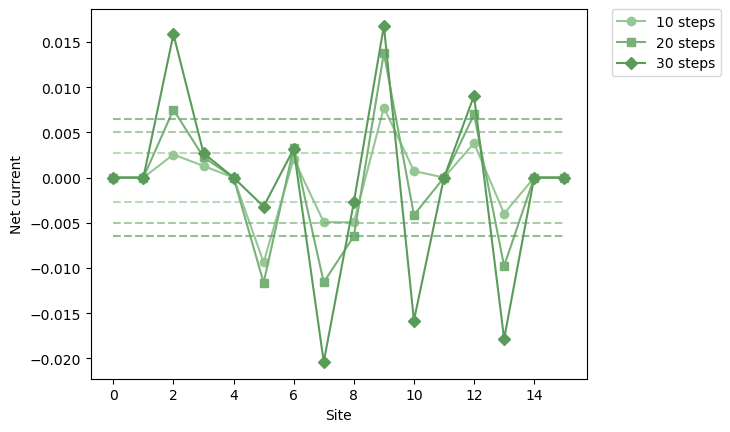

In [ ]:
c1 = np.array([31/256, 119/256, 180/256]) * 0.7
c1_light = np.array([150/256, 200/256, 256/256])

c2 = np.array([255/256, 127/256, 14/256]) * 0.7
c2_light = np.array([255/256, 200/256, 150/256])

c3 = np.array([44/256, 160/256, 44/256]) * 0.7
c3_light = np.array([150/256, 200/256, 150/256])

marker_list = ['o', 's', 'D', '^']

# for ii, num_steps in enumerate([400,500,600,700]):
for ii, num_steps in enumerate([10,20,30]):

    # interpolate the colour from c1_light to c1
    col = c3_light * (1 - ii/4) + c3 * (ii/4)

    plt.plot([0,N-1], [sem_currents[num_steps], sem_currents[num_steps]], "--", alpha=0.65, c=col)
    plt.plot([0,N-1], [-sem_currents[num_steps], -sem_currents[num_steps]], "--", alpha=0.65, c=col)
    plt.plot(np.arange(N), net_currents[num_steps,:], marker=marker_list[ii],  c=col, label=f"{num_steps} steps")

plt.xlabel("Site")
plt.ylabel("Net current")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0.)

plt.show()

if saving_plots:
    plt.savefig(newpath + "equilibrium_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

# plt.savefig(f"../figures/boson_equilibrium_4x4_dt{dt}_p{p}_b{b}_V{V}_tajectories{num_iterations}.png", bbox_inches='tight', pad_inches=0.1, dpi=300)

In [ ]:

filenames = ["bosons_4x4_dt0.25_p0.5_b0.0_V0.0_steps40_trajectories2000_current_random_pinned_corners",
             "bosons_4x4_dt0.25_p0.5_b0.0_V2.0_steps40_trajectories2000_current_random_pinned_corners",
             "bosons_4x4_dt0.25_p0.5_b0.0_V4.0_steps40_trajectories2000_current_random_pinned_corners"]

for ii, filename in enumerate(filenames):

    K_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "K_avg")

    driving_current = (K_avg[1,:] + K_avg[4,:] + K_avg[6,:] + K_avg[8,:] + 2*K_avg[7,:]) / 2

    plt.plot(t_list[1:], driving_current/dt, alpha=0.2, c=f"C{ii}")#, label=f"Inst. V={2*ii}")

    plt.plot(t_list[1:], np.cumsum(driving_current)/t_list[1:], c=f"C{ii}", label=f"V={2*ii}")

plt.xlabel("Time")
plt.ylabel("Driving current")
plt.legend()

# if saving_plots:
    # plt.savefig(newpath + "density_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/arash/Downloads/plotting adams data/data_20250908/fermions_bosons_4x4_dt0.25_p0.5_b0.0_V0.0_steps40_trajectories2000_current_random_pinned_corners.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

---
# Speed Story

[0.         0.71496121 0.74319527 0.75632675 0.75352817 0.74841337
 0.74055009 0.74083642 0.74005891 0.73639158 0.7344298  0.73561722
 0.73459207 0.72999427 0.72778289 0.72373475 0.71993694 0.71330701
 0.70975167 0.7024645  0.69907155]


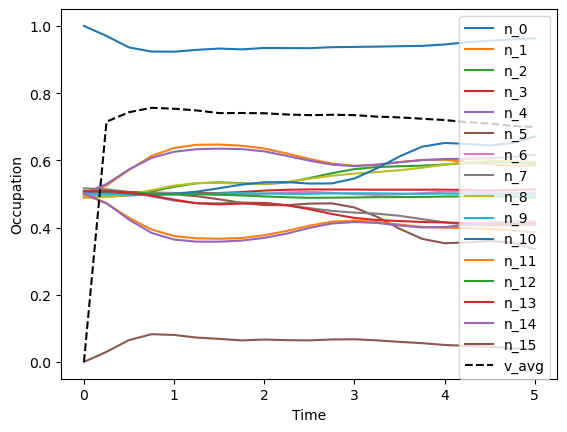

In [93]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg")
spead_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "speed_avg")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
t_list = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny


for i in range(N):
    plt.plot(t_list, n_avg[i,:], label=f"n_{i}")
# plt.plot(t_list, np.sum(n_avg, axis=0)/(num_iterations*N), '--', c='k', label="n_avg")
plt.plot(t_list, spead_avg, '--', c='k', label="v_avg")
# plt.plot(t_list, dt* spead_avg[1]/(num_iterations), ':', c='k', label="E_avg")

plt.xlabel("Time")
plt.ylabel("Occupation")
plt.legend()

print(spead_avg)
# print(spead_avg[1,:]/num_iterations)
# print(spead_avg[2,:]/num_iterations)
if saving_plots:
    plt.savefig(newpath + "relaxpid_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

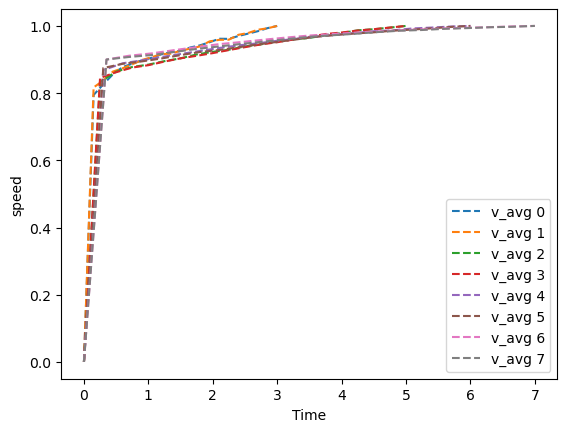

In [25]:
files = [
    "bosons_4x4_dt0.15_p0.3_b0.0_V4.0_steps20_trajectories5000_current_random_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.15_p0.3_b0.0_V4.0_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.25_p0.5_b0.0_V4.0_steps20_trajectories5000_current_random_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.25_p0.5_b0.0_V4.0_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.3_p0.6_b0.0_V4.0_steps20_trajectories5000_current_random_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.3_p0.6_b0.0_V4.0_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.35_p0.7_b0.0_V4.0_steps20_trajectories5000_current_random_pinned_corners_trotter_Adam",
    "bosons_4x4_dt0.35_p0.7_b0.0_V4.0_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter_Adam"
]

for x, file in enumerate(files):
    spead_avg = load_key_from_hdf5(folder_path+f"{file}.h5", "speed_avg")
    params = load_key_from_hdf5(folder_path+f"{file}.h5", "params")
    t_list = load_key_from_hdf5(folder_path+f"{file}.h5", "t_list")

    Nx = params['Nx']
    Ny = params['Ny']
    N = Nx * Ny

    max_speed = np.max(spead_avg)
    plt.plot(t_list, spead_avg/max_speed, '--', c=f'C{x}', label=f"v_avg {x}")


# plt.plot(t_list, dt* spead_avg[1]/(num_iterations), ':', c='k', label="E_avg")

plt.xlabel("Time")
plt.ylabel("speed")
plt.legend()

# print(spead_avg)
# print(spead_avg[1,:]/num_iterations)
# print(spead_avg[2,:]/num_iterations)
if saving_plots:
    plt.savefig(newpath + "relaxpid_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

---
# Comparing Ham vs QC results

## density & error compare

0.11740820392838994
0.10890058552167109
0.09457648487790671
0.08784263378132952
0.08808255204269326
0.09240741853921916
0.10744267311961704
0.11781258144428824
0.11819714834097475
0.11055908687021285
0.09591102419628528
0.0885577644770835
0.08861730373453003
0.09060142256861385
0.10829813459778785
0.11409981040522103


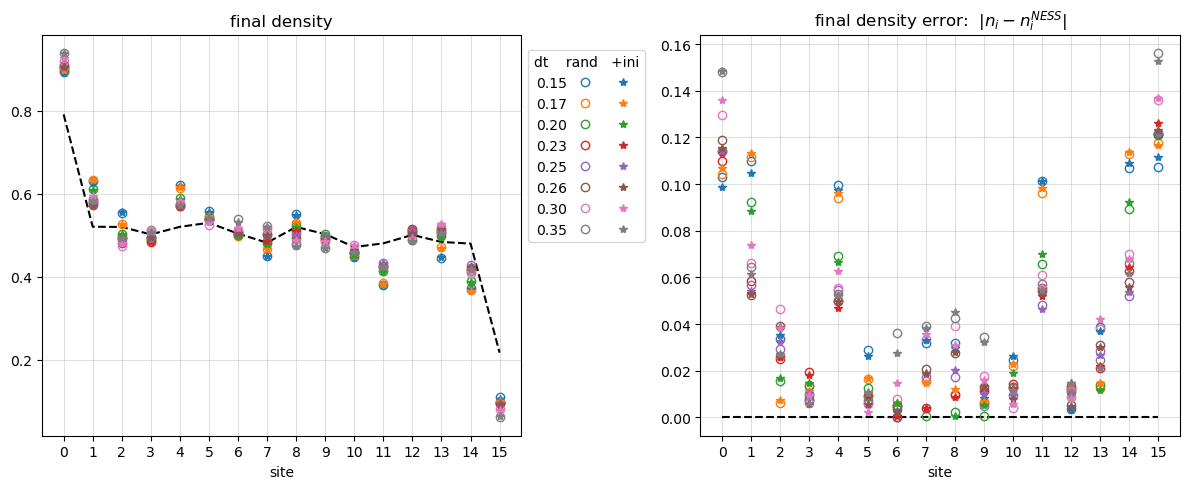

In [ ]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
n_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_sq_avg")
n_sem = np.sqrt(n_sq_avg - n_avg**2)/np.sqrt(num_iterations)

Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny


dt_list = [0.15,0.17,0.20,0.23,0.25,0.26,0.30,0.35]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(np.arange(N), n_avg[:, -1], '--', c=f'k')#, label=f"ED")
ax[1].plot(np.arange(N), np.zeros(N), '--', c=f'k')#, label=f"ED")

for x, dtt in enumerate(dt_list):
    file = glob.glob(f"{particle_name}_4x4_dt{dtt}_p{2*dtt}_b{b}_V{V}_steps20_trajectories????_current_random_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0]
    n_loop = load_key_from_hdf5(folder_path+file, "n_avg")
    ax[0].plot(np.arange(N, dtype=np.int8), n_loop[:,-1], ls='', marker='o', markerfacecolor='none', c=f'C{x}', label=f"{dtt:.2f}")

    data = np.abs(n_avg[:,-1]-n_loop[:,-1])#/n_avg[:,-1]
    ax[1].plot(np.arange(N, dtype=np.int8), data, ls='', marker='o', markerfacecolor='none', c=f'C{x}', label=f"{dtt:.2f}")

    print(np.average(np.abs(n_avg[:,-1]-n_loop[:,-1])/n_avg[:,-1]))

ax[0].set_xlabel("site")
ax[0].set_xticks(range(N), range(N))#, rotation='vertical')
ax[0].set_title("final density")
ax[0].grid(alpha=0.4)

for x, dtt in enumerate(dt_list):
    file = glob.glob(f"{particle_name}_4x4_dt{dtt}_p{2*dtt}_b{b}_V{V}_steps20_trajectories????_current_random_NESS_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0]
    n_loop = load_key_from_hdf5(folder_path+file, "n_avg")
    ax[0].plot(np.arange(N, dtype=np.int8), n_loop[:,-1], ls='', marker='*', c=f'C{x}', label=" ")#label=f"{dtt:.2f}+")

    data = np.abs(n_avg[:,-1]-n_loop[:,-1])#/n_avg[:,-1]
    ax[1].plot(np.arange(N, dtype=np.int8), data, ls='', marker='*', c=f'C{x}', label=f"{dtt:.2f}")

    print(np.average(np.abs(n_avg[:,-1]-n_loop[:,-1])/n_avg[:,-1]))
    # print(np.abs(n_avg[:,-1]-n_loop[:,-1]))

# plt.plot(t_list, dt* spead_avg[1]/(num_iterations), ':', c='k', label="E_avg")

ax[1].set_xlabel("site")
ax[1].set_title(r"final density error:  $|n_i - n_i^{NESS}|$")
ax[1].set_xticks(range(N), range(N))#, rotation='vertical')
ax[1].grid(alpha=0.4)

ax[0].legend(ncol=2, markerfirst=False,
           loc='upper left', bbox_to_anchor=(1.0, 0.98),
           title="dt"+" "*4+"rand"+" "*3+"+ini",
            columnspacing=0.2, handletextpad=0.25)

fig.tight_layout()
if saving_plots:
    plt.savefig(newpath + "DenCmp_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

## current comparison

2.4883952475872406
1.9863486283587473
1.3423257534826731
1.083255069556302
1.1421227991105072
1.2176567123316335
1.010072552058303
1.6383842082233442
2.4746842985553927
1.988571490255556
1.2781342707078351
1.1336927636849317
1.1030529667508022
1.2231918935610007
1.098172621721306
1.6786505794970945


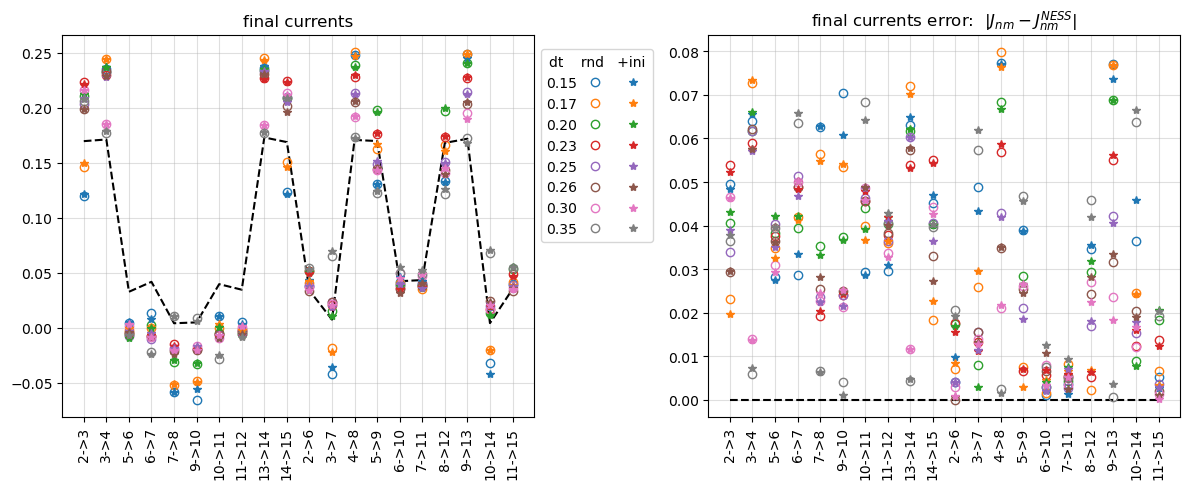

In [77]:
avg_current = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents")
params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
bonds = [f"{i}->{f}" for i,f in params['bonds']]
current_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "currents_sq_avg")
sem_current = 5*np.sqrt(current_sq_avg - avg_current**2)/np.sqrt(num_iterations)
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny

suffix = "_Adam" if not fermions else ""
# files = [
#     f"{particle_name}_4x4_dt0.15_p0.3_b{b}_V{V}_steps20_trajectories5000_current_random_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.15_p0.3_b{b}_V{V}_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.25_p0.5_b{b}_V{V}_steps20_trajectories5000_current_random_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.25_p0.5_b{b}_V{V}_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.3_p0.6_b{b}_V{V}_steps20_trajectories5000_current_random_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.3_p0.6_b{b}_V{V}_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.35_p0.7_b{b}_V{V}_steps20_trajectories5000_current_random_pinned_corners_trotter{suffix}",
#     f"{particle_name}_4x4_dt0.35_p0.7_b{b}_V{V}_steps20_trajectories5000_current_random_NESS_pinned_corners_trotter{suffix}"
# ]

dt_list = [0.15,0.17,0.20,0.23,0.25,0.26,0.30,0.35]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(np.arange(20), avg_current[:, -1], '--', c=f'k')#, label=f"ED")
ax[1].plot(np.arange(20), np.zeros(20), '--', c=f'k')#, label=f"ED")
# plt.fill_between(np.arange(20), avg_current[:, -1] - sem_current[:, -1], avg_current[:, -1] + sem_current[:, -1], alpha=0.2, color=f"k")


for x, dtt in enumerate(dt_list):
    file = glob.glob(f"{particle_name}_4x4_dt{dtt}_p{2*dtt}_b{b}_V{V}_steps20_trajectories????_current_random_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0]
    current = load_key_from_hdf5(folder_path+file, "avg_currents")
    ax[0].plot(np.arange(20, dtype=np.int8), current[:,-1], ls='', marker='o', markerfacecolor='none',c=f'C{x}', label=f'{dtt:.2f}')

    data = np.abs((avg_current[:,-1]-current[:,-1]))#/avg_current[:,-1])
    ax[1].plot(np.arange(20, dtype=np.int8), data, ls='', marker='o', markerfacecolor='none',c=f'C{x}', label=f'{dtt:.2f}')
    print(np.average(np.abs((avg_current[:,-1]-current[:,-1])/avg_current[:,-1])))

# ax[0].set_xlabel("site")
ax[0].set_xticks(range(20), bonds, rotation='vertical')
# ax[0].set_ylabel("final currents")
ax[0].set_title("final currents")
ax[0].grid(alpha=0.4)


for x, dtt in enumerate(dt_list):
    file = glob.glob(f"{particle_name}_4x4_dt{dtt}_p{2*dtt}_b{b}_V{V}_steps20_trajectories????_current_random_NESS_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0]
    current = load_key_from_hdf5(folder_path+file, "avg_currents")
    ax[0].plot(np.arange(20, dtype=np.int8), current[:,-1], ls='', marker='*',c=f'C{x}', label=" ")#f'{dtt:.2f}')

    data = np.abs((avg_current[:,-1]-current[:,-1]))#/avg_current[:,-1])
    ax[1].plot(np.arange(20, dtype=np.int8), data, ls='', marker='*',c=f'C{x}', label=f'{dtt:.2f}')
 
    print(np.average(np.abs((avg_current[:,-1]-current[:,-1])/avg_current[:,-1])))


# ax[1].set_xlabel("site")
# ax[1].set_ylabel(r"final currents error:  $|J_{nm} - J_{nm}^{NESS}|$")
ax[1].set_title(r"final currents error:  $|J_{nm} - J_{nm}^{NESS}|$")
ax[1].set_xticks(range(20), bonds, rotation='vertical')
ax[1].grid(alpha=0.4)


ax[0].legend(ncol=2, markerfirst=False,
           loc='upper left', bbox_to_anchor=(1.0, 0.98),
           title="dt"+" "*4+"rnd"+" "*3+"+ini",
            columnspacing=0.2, handletextpad=0.25)

fig.tight_layout()
if saving_plots:
    plt.savefig(newpath + "relaxpid_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

## N_J error comparison

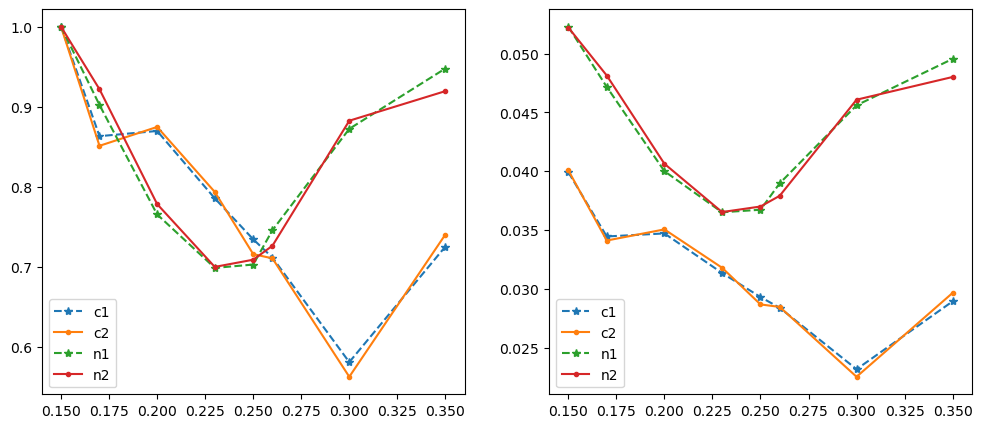

In [78]:
n_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_avg")
avg_current = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "avg_currents")

params = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "params")
bonds = [f"{i}->{f}" for i,f in params['bonds']]

n_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "n_sq_avg")
n_sem = np.sqrt(n_sq_avg - n_avg**2)/np.sqrt(num_iterations)

current_sq_avg = load_key_from_hdf5(folder_path+f"{particle_name}_" + f"{filename}.h5", "currents_sq_avg")
sem_current = 5*np.sqrt(current_sq_avg - avg_current**2)/np.sqrt(num_iterations)

Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny

suffix = "_Adam" if not fermions else ""

dt_list = [0.15,0.17,0.20,0.23,0.25,0.26,0.30,0.35]

fig, ax = plt.subplots(1,2, figsize=(12,5))
# ax[0].plot(np.arange(N), n_avg[:, -1], '--', c=f'k')#, label=f"ED")
# ax[0].plot(np.arange(N), np.zeros(N), '--', c=f'k')#, label=f"ED")

n_data_1, n_data_2 = [], []
c_data_1, c_data_2 = [], []
for x, dtt in enumerate(dt_list):
    file = glob.glob(f"{particle_name}_4x4_dt{dtt}_p{2*dtt}_b{b}_V{V}_steps20_trajectories????_current_random_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0] 
    n_loop = load_key_from_hdf5(folder_path+file, "n_avg")
    n_data = np.mean(np.abs(n_avg[:,-1] - n_loop[:,-1]))#/n_avg[:,-1])
    current = load_key_from_hdf5(folder_path+file, "avg_currents")
    current_data = np.mean(np.abs((avg_current[:,-1]-current[:,-1])))#/avg_current[:,-1]))
    n_data_1.append(n_data)
    c_data_1.append(current_data)

    file = glob.glob(f"{particle_name}_4x4_dt{dtt}_p{2*dtt}_b{b}_V{V}_steps20_trajectories????_current_random_NESS_pinned_corners_trotter{suffix}.h5", root_dir=folder_path)[0]
    n_loop = load_key_from_hdf5(folder_path+file, "n_avg")
    n_data = np.mean(np.abs(n_avg[:,-1] - n_loop[:,-1]))#/n_avg[:,-1])
    current = load_key_from_hdf5(folder_path+file, "avg_currents")
    current_data = np.mean(np.abs((avg_current[:,-1]-current[:,-1])))#/avg_current[:,-1]))
    n_data_2.append(n_data)
    c_data_2.append(current_data)

ax[0].plot(dt_list, c_data_1/np.max(c_data_1), ls='--', marker='*', c=f'C{0}', label="c1")#f'{dtt:.2f}')
ax[0].plot(dt_list, c_data_2/np.max(c_data_2), ls='-', marker='.', c=f'C{1}', label="c2")#f'{dtt:.2f}')
ax[0].plot(dt_list, n_data_1/np.max(n_data_1), ls='--', marker='*', c=f'C{2}', label="n1")
ax[0].plot(dt_list, n_data_2/np.max(n_data_2), ls='-', marker='.', c=f'C{3}', label="n2")

ax[1].plot(dt_list, c_data_1, ls='--', marker='*', c=f'C{0}', label="c1")#f'{dtt:.2f}')
ax[1].plot(dt_list, c_data_2, ls='-', marker='.', c=f'C{1}', label="c2")#f'{dtt:.2f}')
ax[1].plot(dt_list, n_data_1, ls='--', marker='*', c=f'C{2}', label="n1")
ax[1].plot(dt_list, n_data_2, ls='-', marker='.', c=f'C{3}', label="n2")

# ax.plot(dt_list, np.array(c_data_1) * np.array(n_data_1), ls='-', marker='*', c=f'C{0}', label="norm")#f'{dtt:.2f}')
# ax.plot(dt_list, np.array(c_data_2) * np.array(n_data_2), ls='-', marker='.', c=f'C{1}', label="plus")#f'{dtt:.2f}')
# ax.plot(dt_list, n_data_1, ls='-', marker='*', c=f'C{2}', label="n1")
# ax.plot(dt_list, n_data_2, ls='-', marker='.', c=f'C{3}', label="n2")

ax[0].legend()
ax[1].legend()


## N-J SCORE

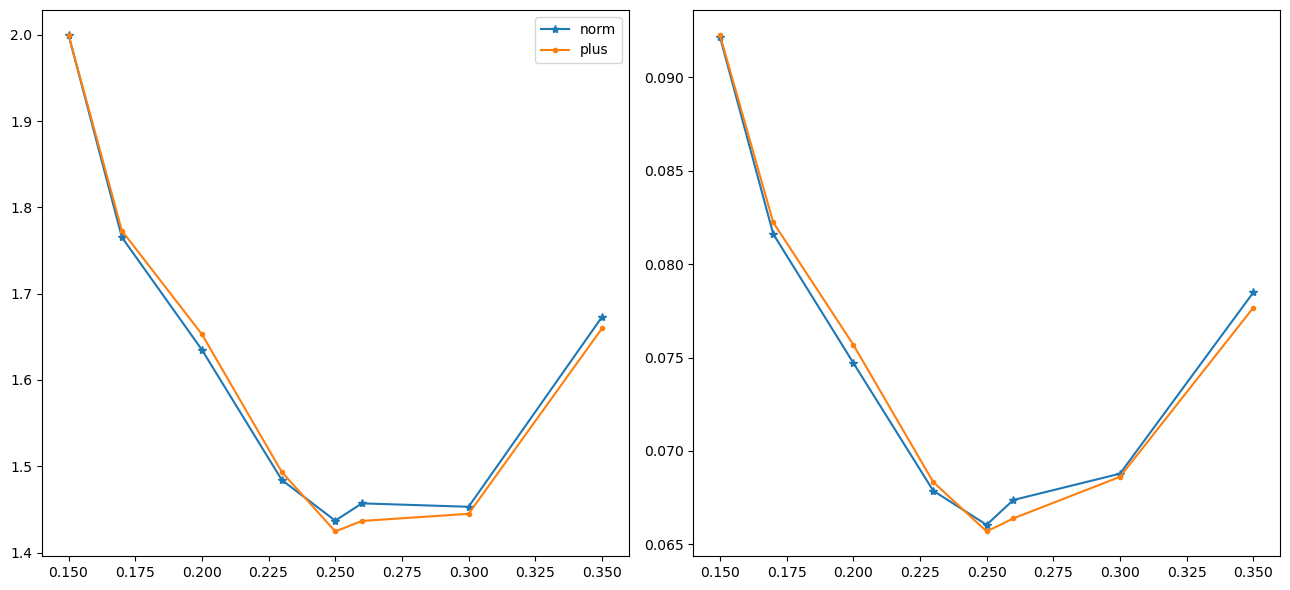

In [79]:

fig, ax = plt.subplots(1,2, figsize=(13,6))
# ax[0].plot(np.arange(N), n_avg[:, -1], '--', c=f'k')#, label=f"ED")
# ax[0].plot(np.arange(N), np.zeros(N), '--', c=f'k')#, label=f"ED")

ax[0].plot(dt_list, np.array(c_data_1/np.max(c_data_1)) + np.array(n_data_1/np.max(n_data_1)), ls='-', marker='*', c=f'C{0}', label="norm")#f'{dtt:.2f}')
ax[0].plot(dt_list, np.array(c_data_2/np.max(c_data_2)) + np.array(n_data_2/np.max(n_data_2)), ls='-', marker='.', c=f'C{1}', label="plus")#f'{dtt:.2f}')

ax[1].plot(dt_list, np.array(c_data_1) + np.array(n_data_1), ls='-', marker='*', c=f'C{0}', label="norm")#f'{dtt:.2f}')
ax[1].plot(dt_list, np.array(c_data_2) + np.array(n_data_2), ls='-', marker='.', c=f'C{1}', label="plus")#f'{dtt:.2f}')



ax[0].legend()

fig.tight_layout()
if saving_plots:
    plt.savefig(newpath + "relaxpid_" + filename + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)

## tests

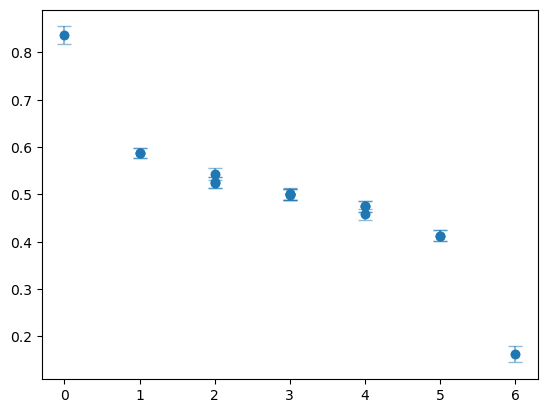

In [ ]:
folder_path_1 = "/Users/arash/Downloads/plotting adams data/data_20250907/"

n_avg_hm = load_key_from_hdf5(folder_path_1+f"{particle_name}_" + f"{filename}.h5", "n_avg")
n_sq_avg_hm = load_key_from_hdf5(folder_path_1+f"{particle_name}_" + f"{filename}.h5", "n_sq_avg")
sem_density = 10*np.sqrt(n_sq_avg_hm - n_avg_hm**2)/np.sqrt(num_iterations)

# params_hm = load_key_from_hdf5(folder_path_1+f"{particle_name}_" + f"{filename}.h5", "params")
# t_list_hm = load_key_from_hdf5(folder_path_1+f"{particle_name}_" + f"{filename}.h5", "t_list")

distance_diagonal = []
for i in range(Nx*Ny):
    x = i % Nx
    y = i // Nx
    distance_diagonal.append(x+y)

fig, ax = plt.subplots()
ax.scatter(distance_diagonal,n_avg_hm[:,-1], marker='o')
ax.errorbar(distance_diagonal, n_avg_hm[:,-1], yerr=sem_density[:,-1], fmt='o', capsize=5, alpha=0.5, color=f"C{0}")


# ax.plot(np.arange(N),n_avg_hm[:,-1])
# ax.plot(np.arange(N),n_avg_hm[:,-1] - sem_density[:,-1], alpha=0.2, color=f"C{0}")
# ax.fill_between(np.arange(N), n_avg_hm[:, -1] - sem_density[:,-1], n_avg_hm[:,-1] + sem_density[:,-1], alpha=0.2, color=f"C{0}")

plt.show()
folder_path_2 = "/Users/arash/Downloads/plotting adams data/data_20250907/"
for dt in [0.15, 0.20, 0.25, 0.30, 0.35]:
    n_avg_qc = load_key_from_hdf5(folder_path_2+f"{particle_name}_" + f"{filename}.h5", "n_avg")
    n_sq_avg_qc = load_key_from_hdf5(folder_path_2+f"{particle_name}_" + f"{filename}.h5", "n_sq_avg")
    params_qc = load_key_from_hdf5(folder_path_2+f"{particle_name}_" + f"{filename}.h5", "params")
    t_list_qc = load_key_from_hdf5(folder_path_2+f"{particle_name}_" + f"{filename}.h5", "t_list")


In [ ]:


print(distance_on_diagonal)    

[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5. 3. 4. 5. 6.]
